In [44]:
# import necessary libraries
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from scipy.sparse.linalg import eigsh
from scipy.signal import find_peaks
from scipy.spatial import Delaunay
from scipy.spatial import distance
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import multiprocessing as mp
from sklearn import metrics
import networkx as nx
import numpy as np
import random
import csv

In [45]:
%run ./functions_for_GrapHiC.ipynb

In [46]:
def plot_points(P, labels, plot_tile, s) :
    plt.figure(figsize = (7, 7))
    plt.scatter(P[:,0], P[:,1], c = labels, cmap = 'rainbow_r', s = s)
    plt.gca().set_aspect('equal'), plt.title(plot_tile), plt.xlabel('x(mm)'), plt.ylabel('y(mm)')
    plt.show()

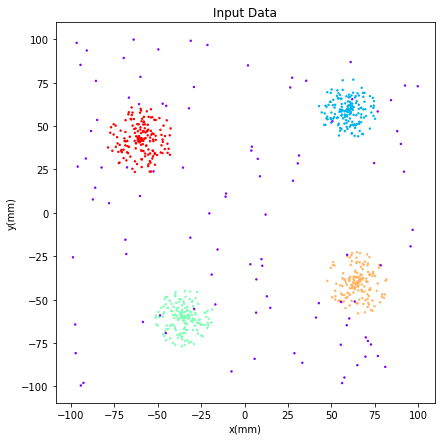

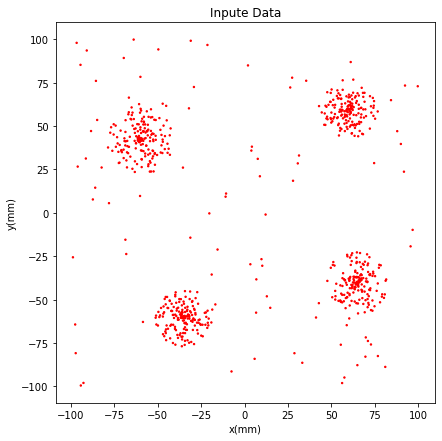

In [47]:
def give_circle_points(rmin, rmax, n_points, center):
    # This function generates "n_points" uniform points inside a circle with center of "center", 
    # and a random radius between "r_min" and "rmax"
    r         = np.random.uniform(rmin, rmax, 1)
    r_s       = np.random.uniform(0, r, n_points)
    theta_s   = np.random.uniform(0, np.pi*2, n_points)
    sin_theta = np.sin(theta_s)
    cos_theta = np.cos(theta_s)
    points    = [[center[0] + r_s[i] * cos_theta[i], center[1] + r_s[i] * sin_theta[i]] for i in range(n_points)]  
    return points


np.random.seed(29)


truelabels = []
k          = 0

centers = [(-60, 42), (65, -40), (-35, -60), (60, 60)]
points  = np.array([[0, 0]])
numbers = [170, 160, 175, 165]  

for i, center in enumerate(centers):
    temp = give_circle_points(16, 20, numbers[i], center)
    truelabels = truelabels + [k for t in list(range(numbers[i]))]
    k          = k + 1
    for t in temp:
        points = np.append(points, [t], axis=0)

points = points[1:]  


noise      = np.random.uniform(low=[-100, -100], high=[100, 100], size=(100,2))
truelabels = truelabels + [k for t in  list(range(100))]
k          = k + 1
for t in noise:
    points = np.append(points, [t], axis=0)

P1              = points 
Sigma1          = np.ones((P1.shape[0], 2, 2)) * 0.5
Sigma1[:, 0, 1] = 0
Sigma1[:, 1, 0] = 0
n1              = np.ones((P1.shape[0], 1)).ravel()
truelabels      = np.array(truelabels)




plot_points(P1, truelabels, 'Input Data', 2)
plot_points(P1, truelabels * 0, 'Inpute Data', 2)

Use GrapHic on my generated data 

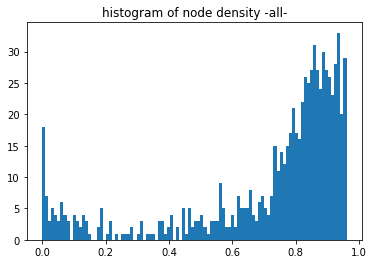

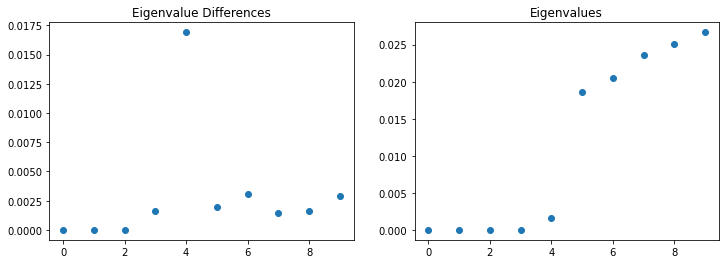

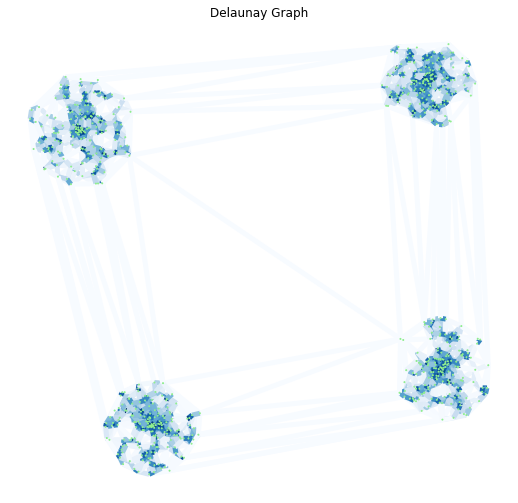

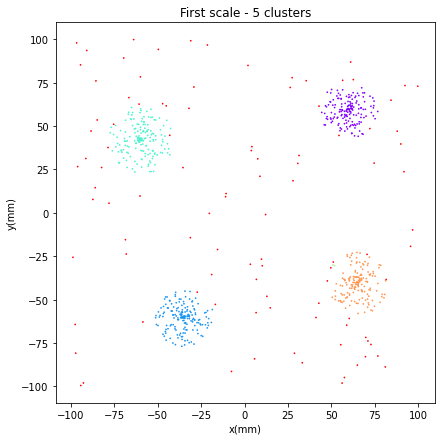

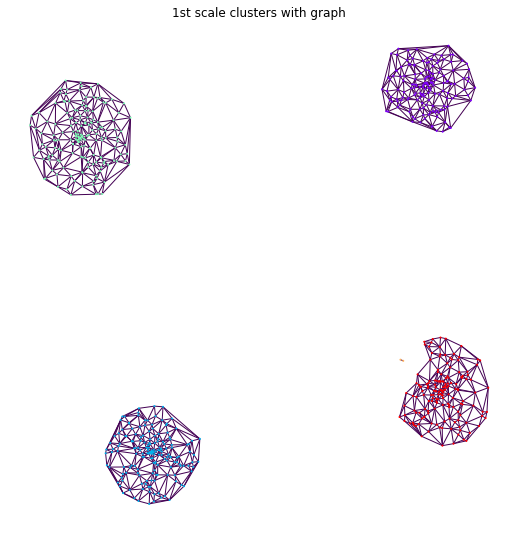

In [42]:
density1, noise_points1, not_noise_points1 = denoise(P1, Sigma1, 5, 0.4, 1)
labels1, G1, k1 = cluster_single_scale(P1, Sigma1, not_noise_points1, 2, 1)
plot_the_graph(G1, P1[not_noise_points1], 'Delaunay Graph', 1)
labels1_fid     = labels1
plot_points(P1, labels1, 'First scale - ' + str(k1) + ' clusters', 0.5)
plot_clusters_with_graph(G1, P1[not_noise_points1], labels1_fid[not_noise_points1], '1st scale clusters with graph', 1)


Use DB-scan on my generated data

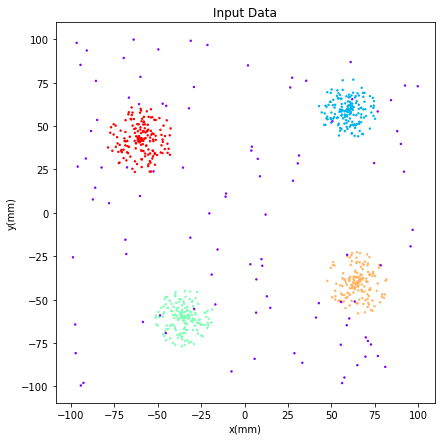

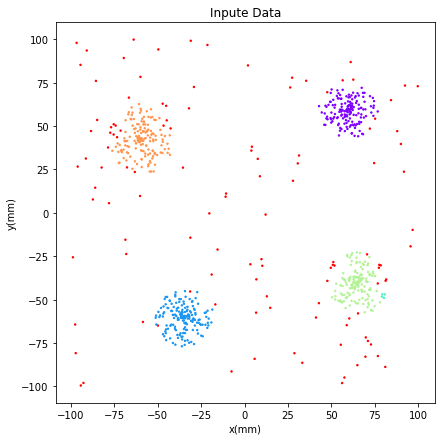

In [54]:
truelabels     = np.array(truelabels)
P              = points 
Sigma          = np.ones((P.shape[0], 2, 2)) * 0.5
Sigma[:, 0, 1] = 0
Sigma[:, 1, 0] = 0
n              = np.ones((P.shape[0], 1)).ravel()


# DBSCAN
db                = DBSCAN(eps=4, min_samples=5).fit(P)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels_db         = db.labels_

plot_points(P, truelabels, 'Input Data', 2)
plot_points(P, labels_db, 'Inpute Data', 2)

In [18]:
# generate data


def give_circle_points(rmin, rmax, n_points, center):
    # This function generates "n_points" uniform points inside a circle with center of "center", 
    # and a random radius between "r_min" and "rmax"
    r         = np.random.uniform(rmin, rmax, 1)
    r_s       = np.random.uniform(0, r, n_points)
    theta_s   = np.random.uniform(0, np.pi*2, n_points)
    sin_theta = np.sin(theta_s)
    cos_theta = np.cos(theta_s)
    points    = [[center[0] + r_s[i] * cos_theta[i], center[1] + r_s[i] * sin_theta[i]] for i in range(n_points)]  
    return points

# ------- 2nd level clusters -------
np.random.seed(29)

centers = [(-25, 25), (120, 40), (50, 125), (90, -25), (125, 90), (46, 50)]
points  = np.array([[0, 0]])
numbers = [18, 12, 21, 8, 8, 9]  
#numbers = [50, 50, 50, 50, 50, 50] 

for i, center in enumerate(centers):
    if i == 5:
        np.random.seed(2)
    temp = give_circle_points(19, 22, numbers[i], center)
    for t in temp:
        points = np.append(points, [t], axis=0)

points = points[1:]  

# ------- 1st level clusters inside 2nd level clusters -------
np.random.seed(29)

centers    = points
points     = np.array([[0, 0]])
truelabels = []
k          = 0

for center in centers:
    temp       = give_circle_points(1.2, 2.4, 15, center)
    truelabels = truelabels + [k for t in list(range(15))]
    k          = k + 1
    for t in temp:
        points = np.append(points, [t], axis=0)

points=points[1:]

# ------- 1st level clusters, dispersed at 2nd scale -------
centers = [(50, -20), (125, 120), (-20, 100), (80, 80), (125, -20),
           (-40, -20), (25, 5), (10, -30), (-10, 145), (75, 25), (150, 75), (10, 75)]

for center in centers:
    temp       = give_circle_points(1.2, 2.4, 15, center)
    truelabels = truelabels + [k for t in list(range(15))]
    k          = k + 1
    for t in temp:
        points = np.append(points, [t], axis=0)
        
# ------- noise -------
noise      = np.random.uniform(low=[-50, -50], high=[150, 150], size=(100,2))
truelabels = truelabels + [k for t in  list(range(100))]
k          = k + 1
for t in noise:
    points = np.append(points, [t], axis=0)
        
P1              = points 
Sigma1          = np.ones((P1.shape[0], 2, 2)) * 0.5
Sigma1[:, 0, 1] = 0
Sigma1[:, 1, 0] = 0
n1              = np.ones((P1.shape[0], 1)).ravel()
truelabels      = np.array(truelabels)

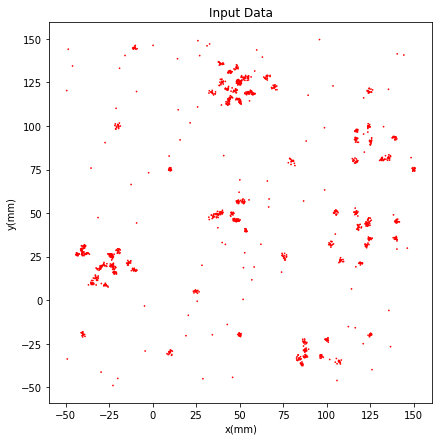

In [19]:
plot_points(P1, truelabels*0, 'Input Data', 0.5)

applying DBscan

Applying GrapHic

--------------------------- First Scale ---------------------------


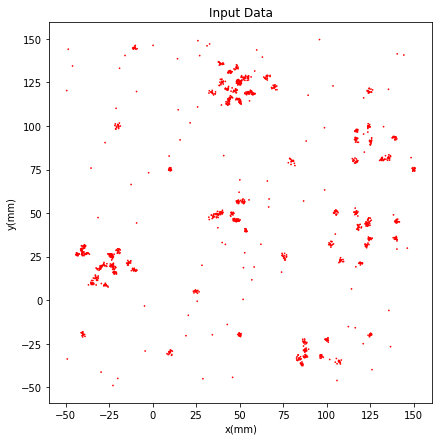

NameError: name 'denoise' is not defined

In [20]:

print('--------------------------- First Scale ---------------------------')
plot_points(P1, truelabels*0, 'Input Data', 0.5)
density1, noise_points1, not_noise_points1 = denoise(P1, Sigma1, 2, 0.2, 1)
labels1, G1, k1 = cluster_single_scale(P1, Sigma1, not_noise_points1, 2, 1)
plot_the_graph(G1, P1[not_noise_points1], 'Delaunay Graph', 1)
labels1_fid     = labels1
plot_points(P1, labels1, 'First scale - ' + str(k1) + ' clusters', 0.5)
plot_clusters_with_graph(G1, P1[not_noise_points1], labels1_fid[not_noise_points1], '1st scale clusters with graph', 1)

print('--------------------------- Second Scale ---------------------------')
P2, Sigma2, n2, cluster_id2  = cluster_to_point(P1[not_noise_points1], Sigma1[not_noise_points1], 
                                   n1[not_noise_points1], k1, labels1[not_noise_points1])
plot_points(P2, n2*0, '2nd scale - input Data', 20)
density2, noise_points2, not_noise_points2 = denoise(P2, Sigma2, 13, 0.15, 1)
labels2, G2, k2 = cluster_single_scale(P2, Sigma2, not_noise_points2, 13, 1)
plot_the_graph(G2, P2[not_noise_points2], 'Delaunay Graph', 10)
labels2_fid, k21 = map_label_to_input(labels1_fid, labels2, k2, cluster_id2)
plot_points(P2, labels2, 'Second scale - ' + str(k2) + ' clusters', 20)
plot_points(P1, labels2_fid, 'Second scale : ' + str(k2) + ' + First sclae : ' + str(12) + '=' + str(k21) + ' clusters', 0.5)
plot_clusters_with_graph(G1, P1[not_noise_points1], labels2_fid[not_noise_points1], '2nd scale clusters with graph', 1)